In [1]:
#imports
import numpy as np
import tensorflow as tf
import cv2
import lucid.scratch.web.svelte as lucid_svelte
import lucid.modelzoo.vision_models as models
import lucid.optvis.render as render
import lucid.optvis.objectives as objectives
import os
import math

from lucid.misc.io import show, load
from lucid.misc.io.showing import _image_url
from lucid_load_model import CovidNetB
from data import process_image_file
from lucid_utils import read_results_file, get_percentile, replace_activations, get_activation_mask

covidnet = CovidNetB()

In [2]:
%%html_define_svelte SemanticDictPercentile

<div class="figure">
    <div class="dropdown">
      <button class="dropbtn">{{labels[label_idx]}}</button>
      <div class="dropdown-content">
        <button on:click="set({label_idx:0})">Normal</button>
        <button on:click="set({label_idx:1})">Pneumonia</button>
        <button on:click="set({label_idx:2})">Covid</button>
      </div>
    </div>
    <div class="image-wrapper">
        <div class="input_image">
            <div class="image" style="background-image: url({{gradcam_urls[label_idx]}}); z-index: -10;"></div>
            <svg class="pointer_container" viewBox="0 0 {{N[0]}} {{N[1]}}">
                {{#each xs as x}}
                {{#each ys as y}}
                  <rect x={{x}} y={{y}} width=1 height=1
                    class={{(x == pos[0] && y == pos[1])? "selected" : "unselected"}}
                    on:mouseover="set({pos: [x,y]})"></rect>
                {{/each}}
                {{/each}}
            </svg>
        </div>
        <div class="image grad-image" style="background-image: url({{image_url}});"></div>
    </div>
    <h1>Positively Fired Neurons</h1>
    <div class="dict" >
        {{#each present_acts as act, act_ind}}
        <div class="entry">
            <p class='dict-text'>{{act.n}}</p>
            <div class="sprite" style="background-image: url({{spritemap_url}}); width: {{sprite_size}}px; height: {{sprite_size}}px; background-position: -{{sprite_size*(act.n%sprite_n_wrap)}}px -{{sprite_size*Math.floor(act.n/sprite_n_wrap)}}px; --info: {{act.n}};"></div>     
            <div class="value" style="width: {{sprite_size*(act.v)/(100)}}px;">
            <p style="font-size:8px;margin-top:0px;margin-bot:0px;padding:0px;color:#FFF;margin-left:10px">{{act.v}}x</p>
            </div>
        </div>
        {{/each}}
    </div>
    <h1>Negatively Fired Neurons</h1>
    <div class="dict" >
        {{#each present_neg_acts as act, act_ind}}
        <div class="entry">
            <p class='dict-text'>{{act.n}}</p>
            <div class="sprite" style="background-image: url({{negative_spritemap_url}}); width: {{sprite_size}}px; height: {{sprite_size}}px; background-position: -{{sprite_size*(act.n%sprite_n_wrap)}}px -{{sprite_size*Math.floor(act.n/sprite_n_wrap)}}px; --info: {{act.n}};"></div>
            <div class="value" style="width: {{sprite_size*(act.v)/(100)}}px;">
            <p style="font-size:8px;margin-top:0px;margin-bot:0px;padding:0px;color:#FFF;margin-left:10px">{{act.v}}x</p>
            </div>
        </div>
        {{/each}}
    </div>
</div>


<style>
    .figure {
        
    }
    .image-wrapper {
        display: flex;
        justify-content: space-between;
    }
    .input_image, .grad-image {
        width:50%;
        max-width: 480px;
        position: relative;
    }
    .image {
        height: 480px;
        background-repeat: no-repeat;
        background-size: cover;
        background-position: center;
    }
    .pointer_container {
        position: absolute;
        top: 0;
        left: 0;
    }
    .pointer_container rect {
      opacity: 0;
    }
    .pointer_container .selected {
      opacity: 1;
      fill: none;
      stroke: hsl(24, 100%, 50%);
      stroke-width: 0.1px;
    }
    .dict {
        display: block;
        vertical-align: bottom;
        padding-bottom: 32px;
        margin-left: 32px;
    }
    .entry {
        margin-top: 9px;
        margin-right: 32px;
        display: inline-block;
    }
    .entry-wrapper {
        margin-top: 9px;
        margin-right: 32px;
        display: block;
    }
    .value {
        display: block;
        height:20px;
        border-radius: 8px;
        background: #777;
    }
    .sprite {
        display: inline-block;
        border-radius: 8px;
        padding:0px;
        margin:0px;
    }
    .dict-text {
        font-size: 12px;
        color: #000;
        margin-bottom: 0px;
        margin-top:5px;
        margin-left:30px;
        margin-right:0px;
        padding:0px;
    }
            
    .dropbtn {
      background-color: #ddd;
      color: white;
      padding: 16px;
      font-size: 16px;
      border: none;
    }

    .dropdown {
      position: relative;
      display: inline-block;
      margin-bottom:10px;
    }

    .dropdown-content {
      display: none;
      position: absolute;
      background-color: #f1f1f1;
      min-width: 160px;
      box-shadow: 0px 8px 16px 0px rgba(0,0,0,0.2);
      z-index: 1;
    }

    .dropdown-content button {
      color: black;
      padding: 12px 16px;
      text-decoration: none;
      display: block;
    }
    .dropdown-content button{
        width:100%;
        border:none;
    }

    .dropdown-content button:hover {background-color: #ddd;}

    .dropdown:hover .dropdown-content {display: block;}

    .dropdown:hover .dropbtn {background-color: #ccc;}

</style>

<script>
    
  function range(n){
    return Array(n).fill().map((_, i) => i);
  }
  
  export default {
    data () {
      return {
        spritemap_url: "",
        sprite_size: 64,
        sprite_n_wrap: 1e8,
        image_url: "",
        activations: [[[{n: 0, v: 1}]]],
        pos: [0,0]
      };
    },
    computed: {
      present_acts: (activations, pos) => activations[pos[1]][pos[0]],
      present_neg_acts: (neg_activations, pos) => neg_activations[pos[1]][pos[0]],
      N: activations => [activations.length, activations[0].length],
      xs: (N) => range(N[0]),
      ys: (N) => range(N[1])
    },
    helpers: {range}
  };
</script>

Trying to build svelte component from html...
svelte compile --format iife C:\Users\CUDDLE~1\AppData\Local\Temp\svelte_pit06b7o\SemanticDictPercentile_0ee30855_ec99_43d9_977a_9d4d4dc99371.html > C:\Users\CUDDLE~1\AppData\Local\Temp\svelte_pit06b7o\SemanticDictPercentile_0ee30855_ec99_43d9_977a_9d4d4dc99371.js
b'svelte version 1.64.1\ncompiling ..\\..\\..\\..\\..\\..\\..\\..\\CUDDLE~1\\AppData\\Local\\Temp\\svelte_pit06b7o\\SemanticDictPercentile_0ee30855_ec99_43d9_977a_9d4d4dc99371.html...\n'


In [3]:
%%html_define_svelte ActivationMask

<div class="figure">
    <div class="image-wrapper">
        <div class="input_image">
            <div class="image" style="background-image: url({{image_url}}); z-index: -10;"></div>
        </div>
        <div class="image grad-image" style="background-image: url({{masked_url}});"></div>
    </div>
</div>


<style>
    .figure {
        
    }
    .image-wrapper {
        display: flex;
        justify-content: space-between;
    }
    .input_image, .grad-image {
        width:50%;
        max-width: 480px;
        position: relative;
    }
    .image {
        height: 480px;
        background-repeat: no-repeat;
        background-size: cover;
        background-position: center;
    }
</style>

Trying to build svelte component from html...
svelte compile --format iife C:\Users\CUDDLE~1\AppData\Local\Temp\svelte_pit06b7o\ActivationMask_15ca296b_684f_4320_a295_fa93e97dc3b8.html > C:\Users\CUDDLE~1\AppData\Local\Temp\svelte_pit06b7o\ActivationMask_15ca296b_684f_4320_a295_fa93e97dc3b8.js
b'svelte version 1.64.1\ncompiling ..\\..\\..\\..\\..\\..\\..\\..\\CUDDLE~1\\AppData\\Local\\Temp\\svelte_pit06b7o\\ActivationMask_15ca296b_684f_4320_a295_fa93e97dc3b8.html...\n'


In [8]:
def get_acts(result='normal_0', layer='conv5_block3_out/add'):
    result_dict = read_results_file()[result]
    image_file = result_dict['image_name']
        
    processed_img = process_image_file(os.path.join('data/test', image_file), 0, 480)
    
    firings_file = 'output/lucid/conv5/firings_distribution.txt'
    #average firing of each channel over entire test set
    firings = np.loadtxt(firings_file)
    
    # Compute the activations
    with tf.Graph().as_default() as graph, tf.Session():
        t_input = tf.placeholder(tf.float32, [480, 480, 3])
        T = render.import_model(covidnet, t_input, t_input)
        acts = T(layer).eval({t_input: processed_img})[0]
    
    acts = -acts
    replace_activations(acts, firings)

    tf.Session().close()
    
    return acts

In [9]:
def covidnet_activation_mask(result='normal_0', channel=0, acts=None):
    #'dab2f334-331c-42c7-af09-a997092464b0.png'
    result_dict = read_results_file()[result]
    image_file = result_dict['image_name']
        
    processed_img = process_image_file(os.path.join('data/test', image_file), 0, 480)
    
    if (acts is None):
        acts = get_acts(result)
    
    #get the masked image
    masked_img = get_activation_mask(processed_img, acts, channel)
    
    lucid_svelte.ActivationMask({
        "image_url": _image_url(processed_img),
        "masked_url": _image_url(masked_img),
    })

In [10]:
def covidnet_semantic_dict_percentile_result(layer='conv5_block3_out/add', result='normal_0', output_class = None, acts=None):
    #'dab2f334-331c-42c7-af09-a997092464b0.png'
    mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
    result_dict = read_results_file()[result]
    image_file = result_dict['image_name']
    if(output_class == None):
        output_class = result_dict['predicted_label']
        
    processed_img = process_image_file(os.path.join('data/test', image_file), 0, 480)
    processed_gradcam_normal = processed_gradcam = cv2.resize(
        cv2.cvtColor(cv2.imread(os.path.join('output/gradcam/no_crop/','normal',image_file)), cv2.COLOR_BGR2RGB), (480,480))
    processed_gradcam_pneumonia = processed_gradcam = cv2.resize(
        cv2.cvtColor(cv2.imread(os.path.join('output/gradcam/no_crop/','pneumonia',image_file)), cv2.COLOR_BGR2RGB), (480,480))
    processed_gradcam_covid = processed_gradcam = cv2.resize(
        cv2.cvtColor(cv2.imread(os.path.join('output/gradcam/no_crop/','COVID-19',image_file)), cv2.COLOR_BGR2RGB), (480,480))
    
    #spritemap_n, spritemap_location, negative_spritemap_location, firings_file = covidnet_spritemap(layer)
    spritemap_n = 46
    spritemap_location = 'output/lucid/conv5/positive.png'
    negative_spritemap_location = 'output/lucid/conv5/negative.png'
    
    if (acts is None):
        acts = get_acts(result)
    
    #find maximum and minimum activation
    acts_max = np.amax(acts)
    acts_min = np.amin(acts)
    
    print(f"Input: {image_file}\nGround Truth: {result_dict['true_label']}\nPrediction: {result_dict['predicted_label']}\nSoftmax Values: {result_dict['softmax_values']}")
    
    lucid_svelte.SemanticDictPercentile({
        "spritemap_url":spritemap_location,
        "negative_spritemap_url":negative_spritemap_location,
        "sprite_size":128,
        "sprite_n_wrap":spritemap_n,
        "image_url": _image_url(processed_img),
        "gradcam_urls": [_image_url(processed_gradcam_normal), _image_url(processed_gradcam_pneumonia), _image_url(processed_gradcam_covid)],
        "activations": [[[{"n": n.tolist(), "v": float(act_vec[n])} for n in np.flip(np.argsort(act_vec)[-5:])] for act_vec in act_slice] for act_slice in acts],
        "neg_activations": [[[{"n": n.tolist(), "v": float(act_vec[n])} for n in np.argsort(act_vec)[:5]] for act_vec in act_slice] for act_slice in acts],
        "pos" : [int(0), int(0)],
        "label_idx":mapping[result_dict['predicted_label']],
        "labels":['normal','pneumonia','covid']
    })

In [11]:
#suppress warnings from tensorflow
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

In [12]:
return_dict = read_results_file(print_dict=True)

found 97 most correct normal evals
found 89 most correct pneumonia evals
found 53 most correct covid evals
found 18 incorrect evals
{'normal_0': {'image_name': '47c78742-4998-4878-aec4-37b11b1354ac.png', 'true_label': 'normal', 'predicted_label': 'normal', 'softmax_values': [0.9935413599014282, 0.006458567455410957, 5.6075442955716426e-08], 'predicted_value': 0.9935413599014282}, 'normal_1': {'image_name': '8989e25c-a698-48fc-b428-fff56931fc8f.png', 'true_label': 'normal', 'predicted_label': 'normal', 'softmax_values': [0.9125339388847351, 0.08746455609798431, 1.5529356005572481e-06], 'predicted_value': 0.9125339388847351}, 'normal_2': {'image_name': '7fb3786c-5045-4a90-981d-c55b53d4d5d3.png', 'true_label': 'normal', 'predicted_label': 'normal', 'softmax_values': [0.9519440531730652, 0.04805486276745796, 1.109711092794896e-06], 'predicted_value': 0.9519440531730652}, 'normal_3': {'image_name': '766b8aea-3b43-4a34-b675-09f373ca066b.png', 'true_label': 'normal', 'predicted_label': 'norma

Input: COVID-19(116).png
Ground Truth: COVID-19
Prediction: COVID-19
Softmax Values: [5.328402215981631e-12, 3.509686541391943e-09, 1.0]



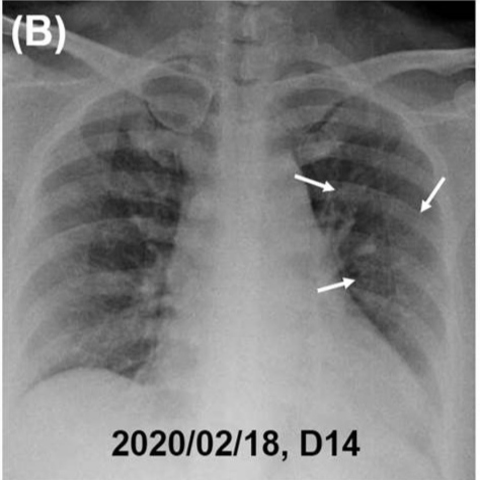
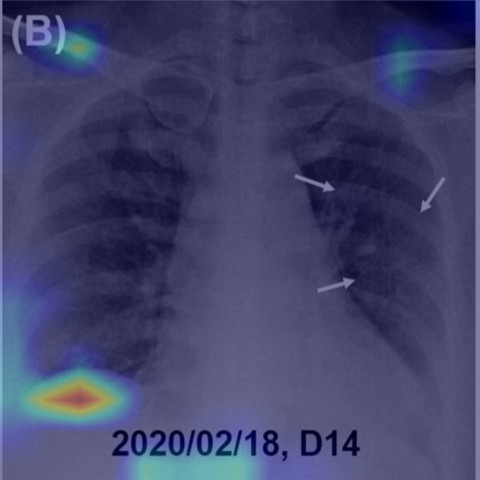
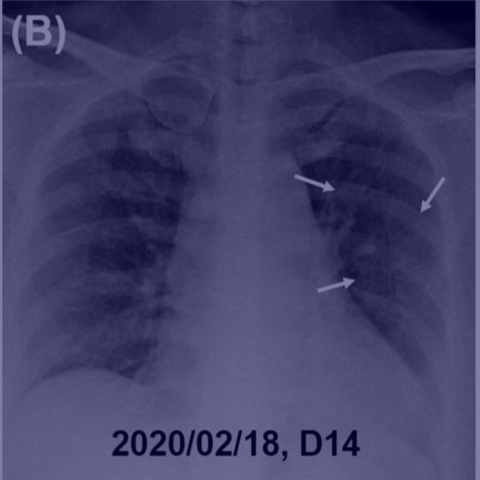
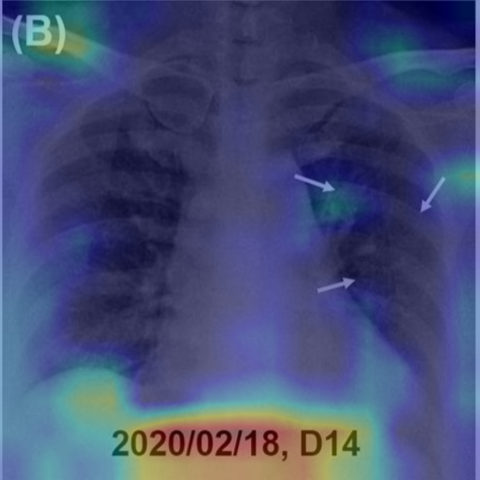

In [14]:
covidnet_semantic_dict_percentile_result(result='covid_49')


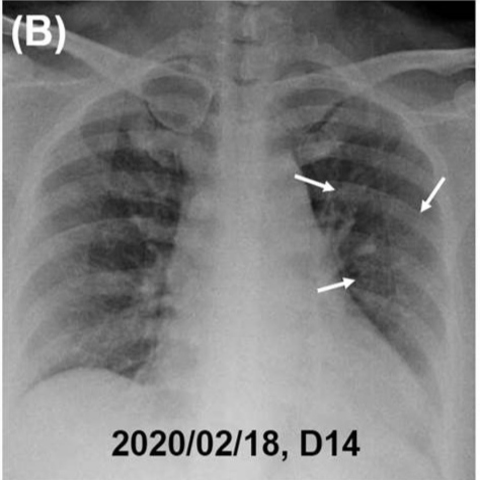
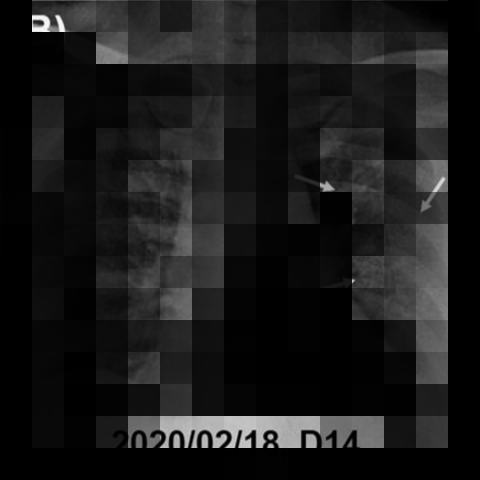

In [11]:
covidnet_activation_mask(result='covid_49', channel=955)


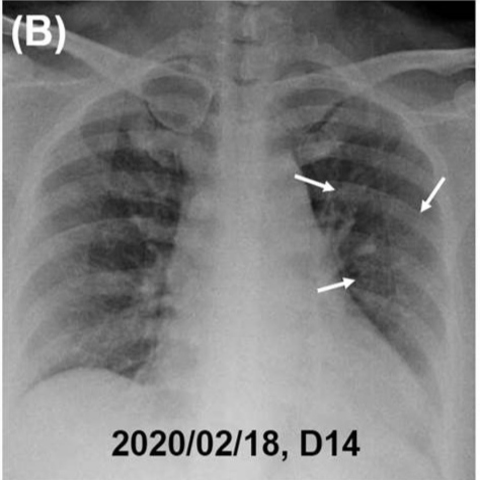
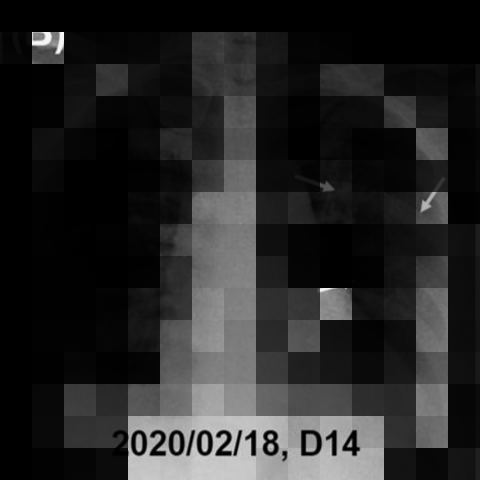

In [13]:
covidnet_activation_mask(result='covid_49', channel=1667)


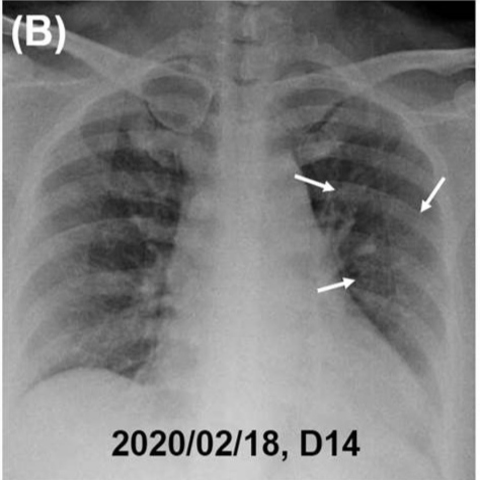
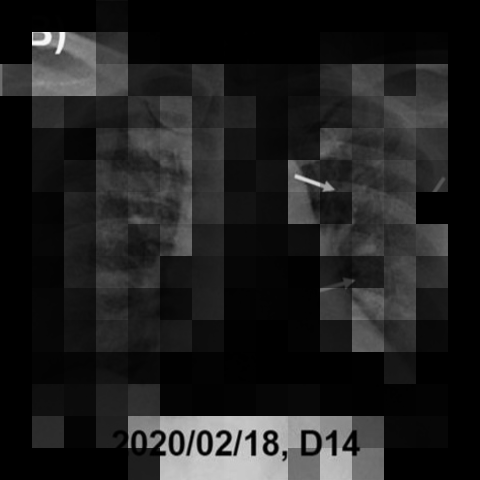

In [14]:
covidnet_activation_mask(result='covid_49', channel=671)